# 31JAN23 Figure Code
Module: Introduction to BIOL 1435 & Evolutionary Genetics \
Topic: Describing variation and patterns of diversity.

In [1]:
# Import modules.
import demes
import demesdraw
import itertools
import math
from matplotlib import pyplot as plt
import msprime
import numpy as np
import random
import toyplot
import toyplot.svg
# Print versions.
print('toyplot', toyplot.__version__)
print('numpy', np.__version__)

toyplot 1.0.3
numpy 1.23.5


## Plot a diagram of possible mutations.

In [2]:
# Intialize a list of all possible mutations.
mutations = [i for i in itertools.permutations('ACGT', r=2)]
# Define a set of transitions.
transitions = {('A','G'), ('C','T')}
# Intialize a list to store colors.
colors = []
# For every set of mutations....
for mut in mutations:
    # Sort the the mutations alphebetically.
    sorted_mut = tuple(sorted(list(mut)))
    # If the mutatation is a transition...
    if sorted_mut in transitions:
        # Append blue to the color list.
        colors.append('blue')
    else:
        # Append red to the color list.
        colors.append('red')

In [3]:
# Plot the mutations graph.
canvas, axes, graph = toyplot.graph(
        [i[0] for i in mutations],
        [i[1] for i in mutations],
        ecolor=colors,
        ewidth=5,
        eopacity=0.35,
        width=350,
        height=350,
        margin=0,
        tmarker='>', 
        vsize=50,
        vcoordinates=[(-1,1),(-1,-1),(1,1), (1,-1)],
        vstyle={'stroke': 'black', 'stroke-width': 2, 'fill': 'none'},
        vlstyle={'font-size': '20px'},
        layout=toyplot.layout.FruchtermanReingold(edges=toyplot.layout.CurvedEdges()),
)
# Plot the transition vs transversion text.
f_style = {'font-size': '14px'} 
canvas.text(175,40, 'Transitions', style=f_style)
canvas.text(175,310, 'Transitions', style=f_style)
canvas.text(40,175, 'Transversions', angle=90, style=f_style)
canvas.text(175,175, 'Transversions', style=f_style)
canvas.text(310,175, 'Transversions', angle=270, style=f_style);

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="350.0px" height="350.0px" viewBox="0 0 350.0 350.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t2e5679bad10249a68bade2ccca9d0de8"> A C G T Transitions Transitions Transversions Transversions Transversions

In [4]:
# Save as a svg.
toyplot.svg.render(canvas, '../figures/31jan23_mutations.svg')

## Plot a toy example of the unfolded SFS from the genotype matrix in lecture.

In [5]:
# Intialize the example matrix from the lecture slides,
# which has a shape of 5 sites x 5 chromosomes.
geno_mat = np.array([
    [0, 0, 0, 0, 0],
    [0, 1, 1, 0, 1],
    [0, 1, 0, 1, 1],
    [0, 0, 0, 0, 1],
    [1, 0, 0, 0, 0],
])
# Calculate the derived allele frequency.
der_freqs = np.sum(geno_mat, axis=1) / geno_mat.shape[1]
# Generate an array of all possible frequency classes.
freq_bins = np.arange(0.2, 1, 0.2)
# Intialize a list of bin heights.
bin_heights = []
# For every bin...
for freq_bin in freq_bins:
    # Append the bin height list.
    bin_heights.append(np.count_nonzero((der_freqs == np.round(freq_bin, 1))))

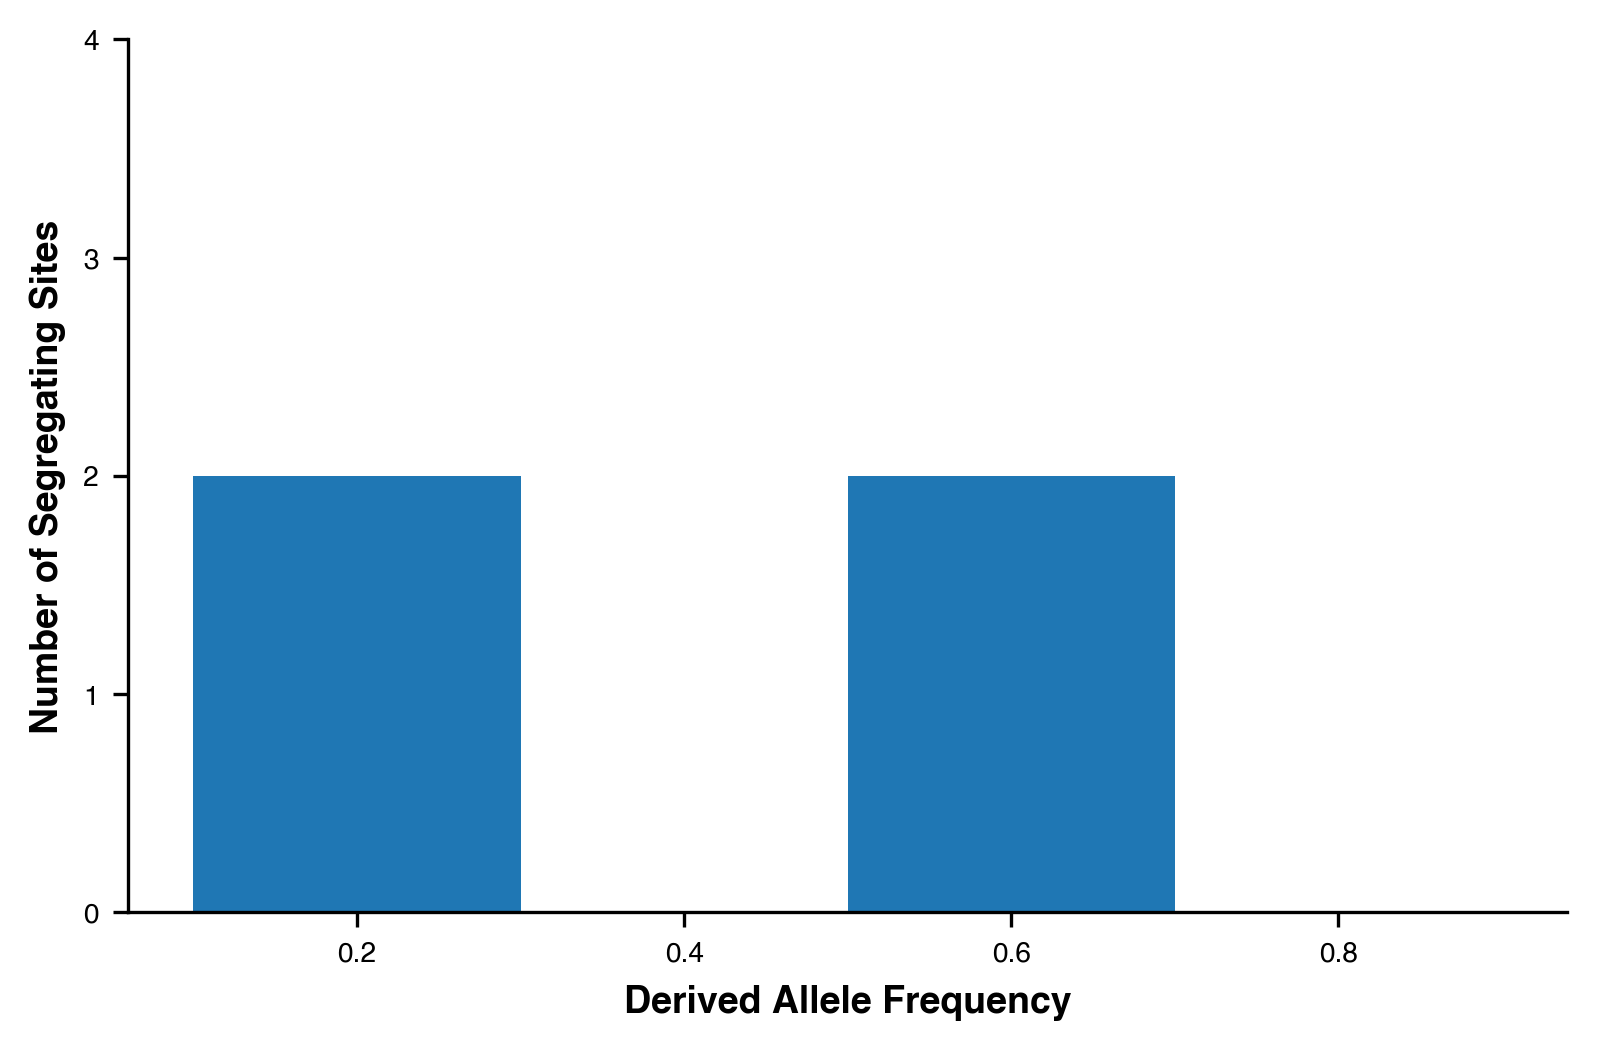

In [6]:
# Update the matplolib style to mimic the toyplot style.
plt.rcParams.update({
    'figure.figsize': (toyplot.units.convert('500px', 'in'), toyplot.units.convert('325px', 'in')),
    'font.family': 'sans-serif',
    'font.sans-serif': 'Helvetica',
    'font.size': toyplot.units.convert('9px', 'pt'),
    'axes.titlesize': toyplot.units.convert('14px', 'pt'),
    'axes.titleweight': 'bold',
    'axes.labelsize': toyplot.units.convert('12px', 'pt'),
    'axes.labelweight': 'bold',
})
# Intialize the figure.
fig = plt.figure(constrained_layout=True, dpi=300.0)
# Intialize the axis.
ax = fig.add_subplot(111)
# Plot the demes graph.
ax.bar(freq_bins, bin_heights, width=0.2)
# Despine the axes.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# Set the x-axis tick positions and labels.
ax.set_xticks([0.2, 0.4, 0.6, 0.8])
ax.set_xticklabels(['0.2', '0.4', '0.6', '0.8'])
# Set the y-axis tick positions and labels.
ax.set_yticks([0, 1, 2, 3, 4])
ax.set_yticklabels(['0', '1', '2', '3', '4'])
# Label the x-axis.
ax.set_xlabel('Derived Allele Frequency')
# Label the y-axis.
ax.set_ylabel('Number of Segregating Sites')
# Save as a svg.
plt.savefig('../figures/31jan23_daf.svg', dpi=300, format='svg')
# Show the figure.
plt.show()

## Plot the three population out of Africa model from Gutenkunst, Ryan N., et al. "Inferring the joint demographic history of multiple populations from multidimensional SNP frequency data." _PLoS genetics_ 5.10 (2009): e1000695.

In [7]:
# Intialize the generation time.
generation_time = 25
# Times are provided in years, so we convert into generations.
T_OOA = 21.2e3 / generation_time
T_AMH = 140e3 / generation_time
T_ANC = 220e3 / generation_time
# We need to work out the starting population sizes based on
# the growth rates provided for these populations.
r_CEU = 0.004
r_CHB = 0.0055
N_CEU = 1000 / math.exp(-r_CEU * T_OOA)
N_CHB = 510 / math.exp(-r_CHB * T_OOA)
N_AFR = 12300
# Intialize an instance of demography.
demography = msprime.Demography()
# Intialize the YRI population.
demography.add_population(
    name='YRI',
    description='Yoruba in Ibadan, Nigeria',
    initial_size=N_AFR,
)
# Intialize the CEU population.
demography.add_population(
    name='CEU',
    description=(
        'Utah Residents (CEPH) with Northern and Western European Ancestry'
    ),
    initial_size=N_CEU,
    growth_rate=r_CEU,
)
# Intialize the CHB population.
demography.add_population(
    name='CHB',
    description='Han Chinese in Beijing, China',
    initial_size=N_CHB,
    growth_rate=r_CHB,
)
# Intialize the OOA population.
demography.add_population(
    name='OOA',
    description='Bottleneck out-of-Africa population',
    initial_size=2100,
)
# Intialize the AMH population.
demography.add_population(
    name='AMH', description='Anatomically modern humans', initial_size=N_AFR
)
# Intialize the ANC population.
demography.add_population(
    name='ANC',
    description='Ancestral equilibrium population',
    initial_size=7300,
)
# CEU and CHB originate from OOA.
demography.add_population_split(time=T_OOA, derived=['CEU', 'CHB'], ancestral='OOA')
# Adjust the migration rate change.
demography.add_symmetric_migration_rate_change(
    time=T_OOA, populations=['YRI', 'OOA'], rate=25e-5
)
# YRI and OOA originate from AMH.
demography.add_population_split(time=T_AMH, derived=['YRI', 'OOA'], ancestral='AMH')
# AMH originaes from ANC.
demography.add_population_split(time=T_ANC, derived=['AMH'], ancestral='ANC')
# Set the migration rates between populations.
demography.set_symmetric_migration_rate(['CEU', 'CHB'], 9.6e-5)
demography.set_symmetric_migration_rate(['YRI', 'CHB'], 1.9e-5)
demography.set_symmetric_migration_rate(['YRI', 'CEU'], 3e-5)

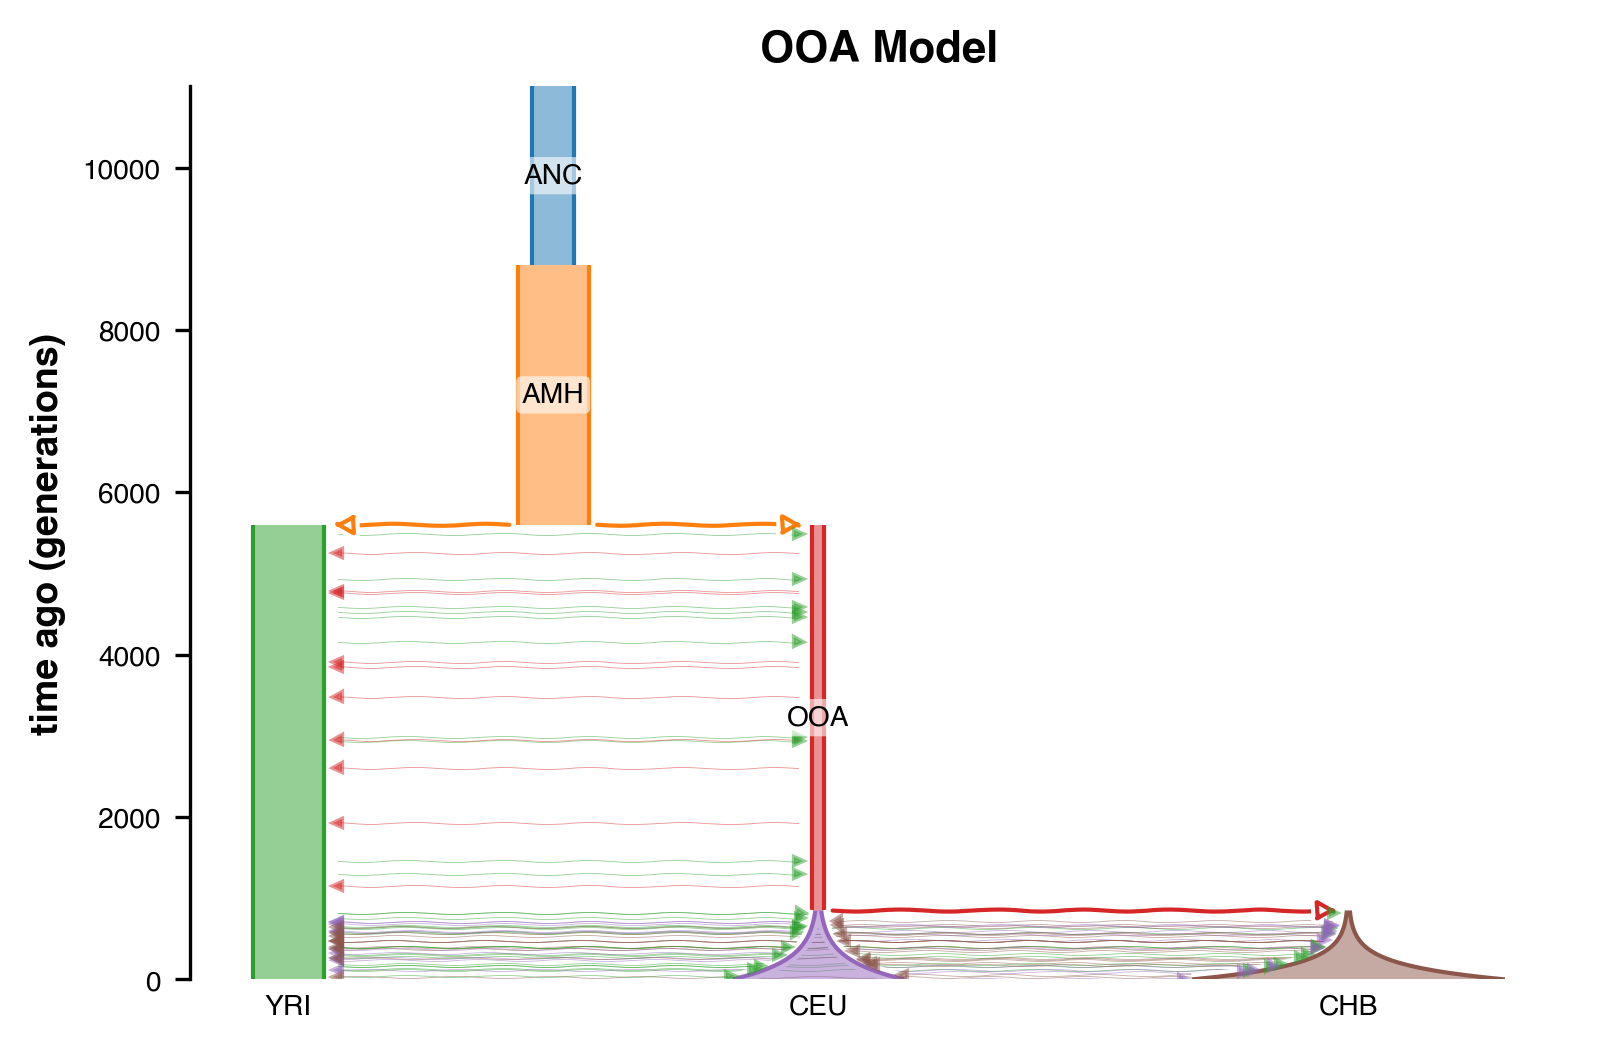

In [8]:
# Convert the demographic object to a demes graph.
demography_graph = msprime.Demography.to_demes(demography)
# Update the matplolib style to mimic the toyplot style.
plt.rcParams.update({
    'figure.figsize': (toyplot.units.convert('500px', 'in'), toyplot.units.convert('325px', 'in')),
    'font.family': 'sans-serif',
    'font.sans-serif': 'Helvetica',
    'font.size': toyplot.units.convert('9px', 'pt'),
    'axes.titlesize': toyplot.units.convert('14px', 'pt'),
    'axes.titleweight': 'bold',
    'axes.labelsize': toyplot.units.convert('12px', 'pt'),
    'axes.labelweight': 'bold',
})
# Intialize the figure.
fig = plt.figure(constrained_layout=True, dpi=300.0)
# Intialize the axes.
ax = fig.add_subplot(111)
# Plot the demes graph.
demesdraw.tubes(demography_graph, ax=ax, title='OOA Model', seed=42)
# Save as a svg.
plt.savefig('../figures/31jan23_ooa.svg', dpi=300, format='svg')
# Show the plot.
plt.show()

## Plot the behavior of gene diversity ($h$) 

$h = 1 - \left(p^{2} + q^{2} \right)$

- $p$ is the frequency of the derived/alternate allele
- $q = \left(1 - p \right)$ which is the frequency of the ancestral/reference allele

In [9]:
# Intialize an array of derived allele frequencies.
p = np.linspace(0, 1, 100)
# Compute gene diversity.
h = 1 - ((p ** 2) + ((1 - p) ** 2))

In [10]:
# Intialize a canvas.
canvas = toyplot.Canvas(
    width=500, height=350,
)
# Intialize and label the axes.
axes = canvas.cartesian(
    xlabel='<i>p</i>',
    ylabel='<i>h</i>',
)
# Plot the results for gene diversity.
axes.plot(p, h)
# Title the plot.
axes.label.text = '<i>h = 1 - (p<sup>2</sup> + ((1 - p)<sup>2</sup>))</i>'

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="500.0px" height="350.0px" viewBox="0 0 500.0 350.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="tbc878ffe5bb54be79543ce9b4473ed40"> <path d="M 50.0 300.0 L 54.04040404040404 290.0010203040507 L 58.08080808080808 280.2061014182226 L 62.121212121212125 270.6152433425162 L 66.16161616161617 261.22844607693094 L 70.20202020202021 252.04570962146718 L 74.24242424242425 243.0670339761249 L 78.28282828282829 234.292419140904 L 82.32323232323233 225.72186511580458 L 86.36363636363637 217.35537190082638 L 90.40404040404042 209.1929394959698 L 94.44444444444444 201.23456790123458 L 98.48484848484848 193.4802571166207 L 102.52525252525254 185.93000714212843 L 106.56565656565658 178.5838179777573 L 110.60606060606061 171.44168962350787 L 114.64646464646465 164.5036220793796 L 118.68686868686869 157.76961534537287 L 122.72727272727273 151.23966942148755 L 126.76767676767678 144.9137843077237 L 130.80808080808083 138.79196000408123 L 134.84848484848484 132.87419651056015 L 138.88888888888889 127.16049382716051 L 142.92929292929296 121.65085195388221 L 146.96969696969697 116.3452708907254 L 151.010101010101 111.24375063768994 L 155.05050505050505 106.34629119477607 L 159.09090909090912 101.65289256198346 L 163.13131313131316 97.16355473931233 L 167.17171717171718 92.87827772676256 L 171.21212121212122 88.79706152433425 L 175.25252525252523 84.91990613202734 L 179.2929292929293 81.24681154984182 L 183.33333333333337 77.7777777777778 L 187.37373737373738 74.51280481583512 L 191.41414141414145 71.45189266401387 L 195.45454545454547 68.59504132231405 L 199.4949494949495 65.94225079073564 L 203.53535353535355 63.49352106927865 L 207.57575757575756 61.24885215794303 L 211.61616161616163 59.20824405672887 L 215.6565656565657 57.3716967656362 L 219.6969696969697 55.73921028466484 L 223.73737373737376 54.3107846138149 L 227.77777777777777 53.08641975308643 L 231.81818181818184 52.06611570247933 L 235.85858585858588 51.249872461993654 L 239.89898989898992 50.63769003162944 L 243.93939393939394 50.2295684113866 L 247.979797979798 50.02550760126519 L 252.02020202020202 50.02550760126519 L 256.0606060606061 50.2295684113866 L 260.1010101010101 50.63769003162944 L 264.14141414141415 51.249872461993654 L 268.18181818181824 52.06611570247933 L 272.22222222222223 53.08641975308643 L 276.2626262626263 54.31078461381495 L 280.3030303030303 55.73921028466484 L 284.34343434343435 57.37169676563615 L 288.3838383838384 59.20824405672893 L 292.42424242424244 61.24885215794308 L 296.4646464646465 63.49352106927865 L 300.5050505050505 65.94225079073564 L 304.5454545454546 68.5950413223141 L 308.5858585858586 71.45189266401387 L 312.6262626262626 74.51280481583512 L 316.66666666666674 77.7777777777778 L 320.7070707070707 81.24681154984188 L 324.74747474747477 84.91990613202739 L 328.7878787878788 88.79706152433425 L 332.8282828282829 92.8782777267626 L 336.8686868686869 97.16355473931233 L 340.90909090909093 101.65289256198346 L 344.949494949495 106.34629119477607 L 348.989898989899 111.24375063769006 L 353.03030303030306 116.34527089072552 L 357.0707070707071 121.65085195388232 L 361.1111111111111 127.16049382716051 L 365.1515151515152 132.87419651056015 L 369.1919191919192 138.79196000408118 L 373.23232323232327 144.9137843077238 L 377.27272727272725 151.23966942148766 L 381.3131313131314 157.76961534537298 L 385.3535353535354 164.50362207937968 L 389.3939393939394 171.44168962350787 L 393.4343434343435 178.5838179777574 L 397.4747474747475 185.93000714212843 L 401.51515151515156 193.4802571166208 L 405.55555555555554 201.23456790123458 L 409.59595959595964 2

In [11]:
# Save as a svg.
toyplot.svg.render(canvas, '../figures/31jan23_gene_diversity.svg')

## Plot the expected shape of the site frequency spectrum  

$\mathbb{E}[sites] = \frac{\theta}{i}$

- $\theta = 2N\mu$
- $i$ the frequency of the derived mutation

In [12]:
# Intialize theta.
N = 10_000
mu = 1.5e-8
theta = 2 * N * mu
# Intialize an array of derived allele frequencies.
i = np.linspace(0, 1, 100)
# Compute expected shape of the sfs.
x_i = theta / i

/var/folders/nr/v5td4f0d4c52kd3_ynmvd7r40000gn/T/ipykernel_20309/471603908.py:8: RuntimeWarning: divide by zero encountered in divide
  x_i = theta / i


In [13]:
# Intialize a canvas.
canvas = toyplot.Canvas(
    width=500, height=350,
)
# Intialize and label the axes.
axes = canvas.cartesian(
    xlabel='<i>i</i>',
    ylabel='<i>x<sub>i</sub></i>',
)
# Plot the results for gene diversity.
axes.plot(i, x_i)
# Title the plot.
axes.label.text = u'\u03b8 = 0.0003'

<svg class="toyplot-canvas-Canvas" xmlns:toyplot="http://www.sandia.gov/toyplot" xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" width="500.0px" height="350.0px" viewBox="0 0 500.0 350.0" preserveAspectRatio="xMidYMid meet" style="background-color:transparent;border-color:#292724;border-style:none;border-width:1.0;fill:rgb(16.1%,15.3%,14.1%);fill-opacity:1.0;font-family:Helvetica;font-size:12px;opacity:1.0;stroke:rgb(16.1%,15.3%,14.1%);stroke-opacity:1.0;stroke-width:1.0" id="t21ac08abda4841f9aca40e006da194ff"> <path d="M 54.04040404040404 52.50000000000003 L 58.08080808080808 176.25000000000003 L 62.121212121212125 217.5 L 66.16161616161617 238.12500000000003 L 70.20202020202021 250.50000000000003 L 74.24242424242425 258.75 L 78.28282828282829 264.6428571428571 L 82.32323232323233 269.0625 L 86.36363636363637 272.5 L 90.40404040404042 275.25 L 94.44444444444444 277.5 L 98.48484848484848 279.375 L 102.52525252525254 280.9615384615385 L 106.56565656565658 282.32142857142856 L 110.60606060606061 283.5 L 114.64646464646465 284.53125 L 118.68686868686869 285.4411764705883 L 122.72727272727273 286.25 L 126.76767676767678 286.9736842105263 L 130.80808080808083 287.625 L 134.84848484848484 288.21428571428567 L 138.88888888888889 288.75 L 142.92929292929296 289.2391304347826 L 146.96969696969697 289.6875 L 151.010101010101 290.1 L 155.05050505050505 290.48076923076917 L 159.09090909090912 290.8333333333333 L 163.13131313131316 291.16071428571433 L 167.17171717171718 291.4655172413793 L 171.21212121212122 291.74999999999994 L 175.25252525252523 292.01612903225805 L 179.2929292929293 292.265625 L 183.33333333333337 292.5 L 187.37373737373738 292.72058823529414 L 191.41414141414145 292.92857142857144 L 195.45454545454547 293.125 L 199.4949494949495 293.3108108108108 L 203.53535353535355 293.4868421052631 L 207.57575757575756 293.6538461538462 L 211.61616161616163 293.8125 L 215.6565656565657 293.9634146341463 L 219.6969696969697 294.1071428571429 L 223.73737373737376 294.24418604651163 L 227.77777777777777 294.375 L 231.81818181818184 294.5 L 235.85858585858588 294.6195652173913 L 239.89898989898992 294.7340425531915 L 243.93939393939394 294.84375 L 247.979797979798 294.94897959183675 L 252.02020202020202 295.05 L 256.0606060606061 295.14705882352945 L 260.1010101010101 295.24038461538464 L 264.14141414141415 295.3301886792452 L 268.18181818181824 295.4166666666667 L 272.22222222222223 295.5 L 276.2626262626263 295.5803571428571 L 280.3030303030303 295.6578947368421 L 284.34343434343435 295.7327586206897 L 288.3838383838384 295.8050847457627 L 292.42424242424244 295.875 L 296.4646464646465 295.94262295081967 L 300.5050505050505 296.008064516129 L 304.5454545454546 296.07142857142856 L 308.5858585858586 296.1328125 L 312.6262626262626 296.1923076923077 L 316.66666666666674 296.25 L 320.7070707070707 296.3059701492537 L 324.74747474747477 296.3602941176471 L 328.7878787878788 296.4130434782609 L 332.8282828282829 296.4642857142857 L 336.8686868686869 296.51408450704224 L 340.90909090909093 296.5625 L 344.949494949495 296.60958904109594 L 348.989898989899 296.65540540540536 L 353.03030303030306 296.70000000000005 L 357.0707070707071 296.7434210526316 L 361.1111111111111 296.7857142857143 L 365.1515151515152 296.82692307692304 L 369.1919191919192 296.86708860759495 L 373.23232323232327 296.90624999999994 L 377.27272727272725 296.9444444444444 L 381.3131313131314 296.9817073170732 L 385.3535353535354 297.0180722891566 L 389.3939393939394 297.05357142857144 L 393.4343434343435 297.0882352941176 L 397.4747474747475 297.1220930232558 L 401.51515151515156 297.15517241379314 L 405.55555555555554 297.1875 L 409.59595959595964 297.2191011235955 L 413.6363636363637 297.25 L 417.67676767676767 297.28021978021974 L 421.71717171717177 297.3097826086957 L 425.75757575757575 297.3387096774194 L 429.79797979797985 297.3670212765957 L 433.8383838383839 297.3947368421052 L 437.8787878787879 297.421875 L 441.9191919191919 297.448

In [14]:
# Save as a svg.
toyplot.svg.render(canvas, '../figures/31jan23_sfs.svg')